In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import gc

from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix, recall_score, accuracy_score
#from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier
from catboost import CatBoostClassifier

warnings.simplefilter("ignore", UserWarning)


PATH = '***'

# Load data #1

## Train

In [2]:
n_neigbours = 30

In [3]:
features_train = pd.read_csv(PATH + 'all_features_train.csv', index_col=0)
target_train = pd.read_csv(PATH + 'target_train.csv', index_col=0)
idx_d_train = pd.read_csv(PATH + 'faiss_idx_and_distances_train.csv', index_col=0)

In [4]:
features_train['distance'] = idx_d_train['1']
#features_train['index'] = idx_d_train['0']
features_train['target'] = target_train

# CatBoost ranking

## GridSearch

Searching for best params on stratified sample (20% of train data):

In [5]:
N = len(features_train)*0.2
train_sample = features_train.groupby('target', group_keys=False).apply(lambda x: x.sample(int(np.rint(N*len(x)/len(features_train))))).sample(frac=1).reset_index(drop=True)

In [6]:
model = CatBoostClassifier(verbose=False, iterations=1000, 
                           random_seed=42, 
                           loss_function='Logloss',
                           boosting_type='Ordered')

params = {'depth': range (3, 10)}

In [7]:
#grid = GridSearchCV(model, params, scoring='f1') 
#grid.fit(train_sample.drop(['target'], axis = 1), train_sample['target'])
#f1 = grid.best_score_
#print('F1 on stratified sample:', round(f1, 3))
#print(grid.best_params_)

## Train model

defining `metrics` function:

In [8]:
def metrics(y_true, y_pred):
    cm = (confusion_matrix(y_true, y_pred))
    print('Accuracy: ', round(accuracy_score(y_true, y_pred), 3))
    print('Precision: ', round(precision_score(y_true, y_pred), 3))
    print('Recall: ', round(recall_score(y_true, y_pred), 3))
    print('F1-score: ', round(f1_score(y_true, y_pred), 3))
#    print('ROC-AUC: ', round(roc_auc_score(y_true, model.predict_proba(features)[:, 1]), 3))
    
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.matshow(cm, cmap=plt.cm.gnuplot, alpha=0.3)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='large')
 
    plt.xlabel('Predictions', fontsize=10)
    plt.ylabel('Actuals', fontsize=10)
    plt.title('Confusion Matrix', fontsize=10)

In [9]:
X = np.array(features_train.drop(['target'], axis = 1))
y = np.array(target_train)

In [10]:
del features_train, target_train, idx_d_train
gc.collect()

0

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2,                         
                                                    random_state=42,
                                                   stratify=y)
print(X_train.shape)
print(X_test.shape)

(2400000, 139)
(600000, 139)


In [12]:
model = CatBoostClassifier(verbose=500, depth=6, 
                           iterations=1500, 
                           random_seed=42, 
                           loss_function='Logloss',
                           boosting_type='Ordered')
model.fit(X_train, y_train)

Learning rate set to 0.197155
0:	learn: 0.3782193	total: 1.59s	remaining: 39m 48s
500:	learn: 0.0462843	total: 12m 52s	remaining: 25m 40s
1000:	learn: 0.0412427	total: 26m 6s	remaining: 13m 1s
1499:	learn: 0.0384998	total: 39m 20s	remaining: 0us


In [13]:
del X_train, y_train
gc.collect()

0

Accuracy:  0.986
Precision:  0.855
Recall:  0.531
F1-score:  0.655


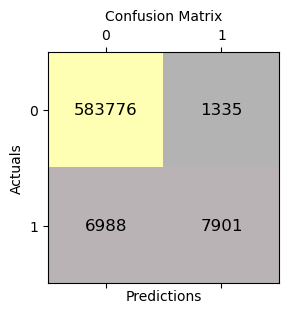

In [14]:
pred = model.predict(X_test)
metrics(y_test, pred)

In [15]:
del X_test, y_test, pred
gc.collect()

2590

## Searching best candidates

defining `best_candidates_search` function:

In [16]:
def best_candidates_search(df, n, cand_num, type):
    best_candidates_list = []
    for i in tqdm(range((len(df)// n))):
        best_c = df[n*i:n*(i+1)].sort_values(by='prob', ascending=False)[:cand_num]
        best_candidates_list.append(best_c)
        del best_c
    print('lists created...')    
    del df
    gc.collect()
    print('origin DF deleted...')    
    new_df = pd.DataFrame(np.concatenate(best_candidates_list))
    print('new DF created!')
    return new_df
    #new_df.to_csv(PATH + 'best_candidates_'+ type + '.csv')
    #print('new DF saved!') 

In [17]:
X = pd.DataFrame(X)
X['prob'] = model.predict_proba(X)[:, 1]
X['target'] = y

creating new smaller train dataframe:

In [18]:
best5_train = best_candidates_search(X, n_neigbours, 5, 'train')

  0%|          | 0/100000 [00:00<?, ?it/s]

lists created...
origin DF deleted...
new DF created!


In [19]:
del X
gc.collect()

0

140
0.0    0.856508
1.0    0.143492
Name: proportion, dtype: float64


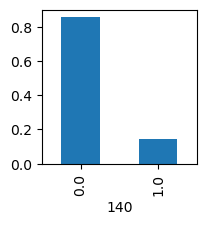

In [20]:
plt.figure(figsize=(2,2))
class_frequency = best5_train[best5_train.shape[1]-1].value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar'); 

# Load data #2

## Validation 

In [21]:
features_valid = pd.read_csv(PATH + 'all_features_valid.csv', index_col=0)
target_valid = pd.read_csv(PATH + 'target_valid.csv', index_col=0)
idx_d_valid = pd.read_csv(PATH + 'faiss_idx_and_distances_valid.csv', index_col=0)

In [22]:
features_valid['distance'] = idx_d_valid['1']

In [23]:
del idx_d_valid
gc.collect()

2547

## Searching best candidates

In [24]:
features_valid['prob'] = model.predict_proba(features_valid)[:, 1]
features_valid['target'] = target_valid

creating new smaller valid dataframe:

In [25]:
best5_valid = best_candidates_search(features_valid, n_neigbours, 5, 'valid')

  0%|          | 0/100000 [00:00<?, ?it/s]

lists created...
origin DF deleted...
new DF created!


In [26]:
del features_valid
gc.collect()

0

140
0.0    0.859226
1.0    0.140774
Name: proportion, dtype: float64


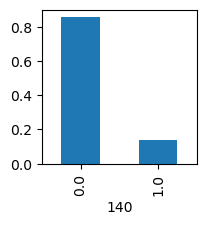

In [27]:
plt.figure(figsize=(2,2))
class_frequency = best5_valid[best5_valid.shape[1]-1].value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar');  

# CatBoost Classification

## Train

In [28]:
y_train = np.array(best5_train[best5_train.shape[1]-1])
X_train = np.array(best5_train.drop([best5_train.shape[1]-1], axis=1))
del best5_train
gc.collect()

2573

In [29]:
y_valid = np.array(best5_valid[best5_valid.shape[1]-1])
X_valid = np.array(best5_valid.drop([best5_valid.shape[1]-1], axis=1))
del best5_valid
gc.collect()

0

In [30]:
model = CatBoostClassifier(verbose=500, depth=6, 
                           iterations=1500, 
                           random_seed=42, 
                           loss_function='Logloss',
                           boosting_type='Ordered')
model.fit(X_train, y_train)

Learning rate set to 0.100906
0:	learn: 0.5673507	total: 423ms	remaining: 10m 33s
500:	learn: 0.1689283	total: 3m 17s	remaining: 6m 34s
1000:	learn: 0.1586496	total: 6m 36s	remaining: 3m 17s
1499:	learn: 0.1518641	total: 9m 53s	remaining: 0us


## Metrics

Accuracy:  0.927
Precision:  0.81
Recall:  0.628
F1-score:  0.708


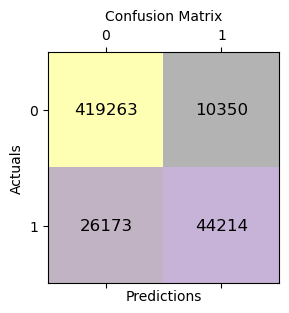

In [31]:
y_pred = model.predict(X_valid)
metrics(y_valid, y_pred)

Compare metrics to a DummyClassifier:

In [32]:
dummy_clf = DummyClassifier(strategy='stratified')
dummy_clf.fit(X_train, y_train)

DummyClassifier(strategy='stratified')

Accuracy:  0.756
Precision:  0.142
Recall:  0.145
F1-score:  0.144


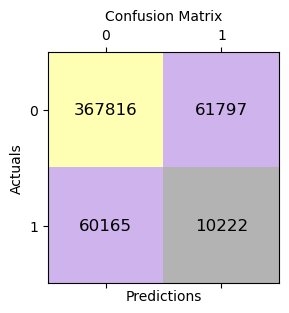

In [33]:
dum_pred = dummy_clf.predict(X_valid)
metrics(y_valid, dum_pred)

![Url](https://y.yarn.co/72d3e314-fac3-4392-96af-8c81554f0a9b_text.gif "jack")

For evaluating performance of the model there will be used *F1 score* and *accuracy*. F1 indicates that the model has both high precision and high recall, which means that it’s able to correctly identify positive cases while avoiding false positives and false negatives.

*F1 score* value is 0.708 on validation, and *accuracy* is 0.927.

# Saving model

In [34]:
model.save_model(PATH + 'matching_model.cbm', format='cbm')